<a href="https://colab.research.google.com/github/ankitrajput77/Deep_Learning_For_Computer_Vision/blob/main/04_human_emotion_analyzer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -q kaggle

In [2]:
! mkdir ~/.kaggle

In [3]:
! cp kaggle.json ~/.kaggle/

In [4]:
!kaggle datasets download -d muhammadhananasghar/human-emotions-datasethes

100% 308M/309M [00:11<00:00, 29.3MB/s]
100% 309M/309M [00:11<00:00, 28.1MB/s]


In [5]:
!unzip "/content/human-emotions-datasethes.zip" -d "/content/dataset/"

Streaming output truncated to the last 5000 lines.
  inflating: /content/dataset/EmotionsDataset/data/nothing/720.jpg  
  inflating: /content/dataset/EmotionsDataset/data/nothing/721.jpg  
  inflating: /content/dataset/EmotionsDataset/data/nothing/722.jpg  
  inflating: /content/dataset/EmotionsDataset/data/nothing/723.jpg  
  inflating: /content/dataset/EmotionsDataset/data/nothing/724.jpg  
  inflating: /content/dataset/EmotionsDataset/data/nothing/725.jpg  
  inflating: /content/dataset/EmotionsDataset/data/nothing/726.jpg  
  inflating: /content/dataset/EmotionsDataset/data/nothing/727.jpg  
  inflating: /content/dataset/EmotionsDataset/data/nothing/728.jpg  
  inflating: /content/dataset/EmotionsDataset/data/nothing/729.jpg  
  inflating: /content/dataset/EmotionsDataset/data/nothing/73.jpg  
  inflating: /content/dataset/EmotionsDataset/data/nothing/730.jpg  
  inflating: /content/dataset/EmotionsDataset/data/nothing/731.jpg  
  inflating: /content/dataset/EmotionsDataset/data/no

In [6]:
import tensorflow as tf### models
import numpy as np### math computations
import matplotlib.pyplot as plt### plotting bar chart
import sklearn### machine learning library
import cv2## image processing
from sklearn.metrics import confusion_matrix, roc_curve### metrics
import seaborn as sns### visualizations
import datetime
import pathlib
import io
import os
import time
import random
from google.colab import files
from PIL import Image
import albumentations as A
import tensorflow_datasets as tfds
import tensorflow_probability as tfp
import matplotlib.cm as cm
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer
from tensorflow.keras.layers import (GlobalAveragePooling2D, Activation, MaxPooling2D, Add, Conv2D, MaxPool2D, Dense,
                                     Flatten, InputLayer, BatchNormalization, Input, Embedding, Permute,
                                     Dropout, RandomFlip, RandomRotation, LayerNormalization, MultiHeadAttention,
                                     RandomContrast, Rescaling, Resizing, Reshape)
from tensorflow.keras.losses import BinaryCrossentropy,CategoricalCrossentropy, SparseCategoricalCrossentropy
from tensorflow.keras.metrics import Accuracy,TopKCategoricalAccuracy, CategoricalAccuracy, SparseCategoricalAccuracy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import (Callback, CSVLogger, EarlyStopping, LearningRateScheduler,
                                        ModelCheckpoint, ReduceLROnPlateau)
from tensorflow.keras.regularizers  import L2, L1
from tensorflow.train import BytesList, FloatList, Int64List
from tensorflow.train import Example, Features, Feature
from google.colab import drive

In [7]:
CONFIGURATION = {
    "BATCH_SIZE": 32,
    "IM_SIZE": 256,
    "LEARNING_RATE": 1e-3,
    "N_EPOCHS": 20,
    "DROPOUT_RATE": 0.0,
    "REGULARIZATION_RATE": 0.0,
    "N_FILTERS": 6,
    "KERNEL_SIZE": 3,
    "N_STRIDES": 1,
    "POOL_SIZE": 2,
    "N_DENSE_1": 1024,
    "N_DENSE_2": 128,
    "NUM_CLASSES": 3,
    "PATCH_SIZE": 16,
    "PROJ_DIM": 768,
    "CLASS_NAMES": ["angry", "happy", "sad"],
}

In [8]:
train_directory = "/content/dataset/Emotions Dataset/Emotions Dataset/train"
val_directory = "/content/dataset/Emotions Dataset/Emotions Dataset/test"

# Data Preperation

In [9]:
train_dataset = tf.keras.utils.image_dataset_from_directory(
    train_directory,
    labels='inferred',
    label_mode='categorical',
    class_names=CONFIGURATION["CLASS_NAMES"],
    color_mode='rgb',
    batch_size=CONFIGURATION["BATCH_SIZE"],
    image_size=(CONFIGURATION["IM_SIZE"], CONFIGURATION["IM_SIZE"]),
    shuffle=True,
    seed=99,
)

Found 6799 files belonging to 3 classes.


In [10]:
val_dataset = tf.keras.utils.image_dataset_from_directory(
    val_directory,
    labels='inferred',
    label_mode='categorical',
    class_names=CONFIGURATION["CLASS_NAMES"],
    color_mode='rgb',
    batch_size=1,#CONFIGURATION["BATCH_SIZE"],
    image_size=(CONFIGURATION["IM_SIZE"], CONFIGURATION["IM_SIZE"]),
    shuffle=True,
    seed=99,
)


Found 2278 files belonging to 3 classes.


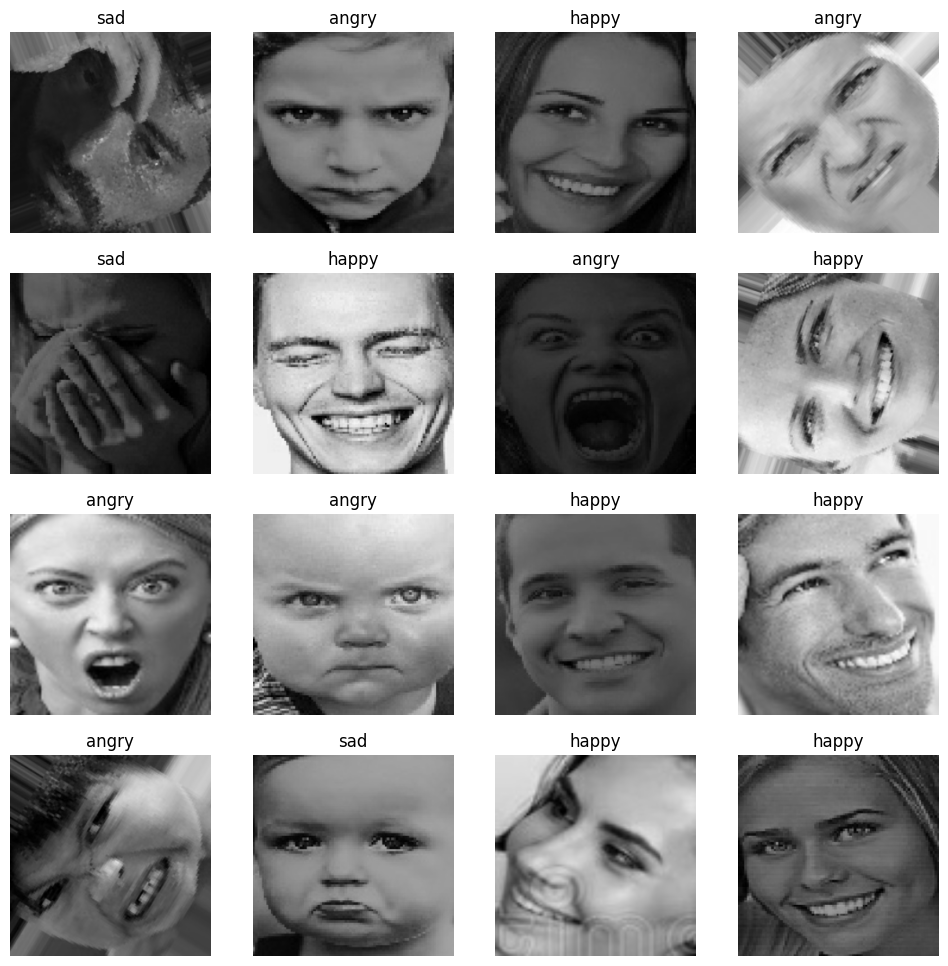

In [11]:
plt.figure(figsize = (12,12))

for images, labels in train_dataset.take(1):
  for i in range(16):
    ax = plt.subplot(4,4, i+1)
    plt.imshow(images[i]/255.)
    plt.title(CONFIGURATION["CLASS_NAMES"][tf.argmax(labels[i], axis = 0).numpy()])
    plt.axis("off")

#Data Augmention

In [12]:
### tf.keras.layer augment
augment_layers = tf.keras.Sequential([
  RandomRotation(factor = (-0.025, 0.025)),
  RandomFlip(mode='horizontal',),
  RandomContrast(factor=0.1),
])

In [13]:
def augment_layer(image, label):
  return augment_layers(image, training = True), label

In [14]:
training_dataset = (
    train_dataset
    .map(augment_layer, num_parallel_calls = tf.data.AUTOTUNE)
    .prefetch(tf.data.AUTOTUNE)
)

In [15]:
validation_dataset = (
    val_dataset
    .prefetch(tf.data.AUTOTUNE)
)

In [16]:
resize_rescale_layers = tf.keras.Sequential([
       Resizing(CONFIGURATION["IM_SIZE"], CONFIGURATION["IM_SIZE"]),
       Rescaling(1./255),
])

In [17]:
training_dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 3), dtype=tf.float32, name=None))>

In [18]:
validation_dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 3), dtype=tf.float32, name=None))>

# Model

In [19]:
lenet_model = tf.keras.Sequential([
    InputLayer(input_shape = (None, None, 3), ),

    resize_rescale_layers,

    Conv2D(filters = CONFIGURATION["N_FILTERS"] , kernel_size = CONFIGURATION["KERNEL_SIZE"], strides = CONFIGURATION["N_STRIDES"] , padding='valid',
          activation = 'relu',kernel_regularizer = L2(CONFIGURATION["REGULARIZATION_RATE"])),
    BatchNormalization(),
    MaxPool2D (pool_size = CONFIGURATION["POOL_SIZE"], strides= CONFIGURATION["N_STRIDES"]*2),
    Dropout(rate = CONFIGURATION["DROPOUT_RATE"] ),

    Conv2D(filters = CONFIGURATION["N_FILTERS"]*2 + 4, kernel_size = CONFIGURATION["KERNEL_SIZE"], strides=CONFIGURATION["N_STRIDES"], padding='valid',
          activation = 'relu', kernel_regularizer = L2(CONFIGURATION["REGULARIZATION_RATE"])),
    BatchNormalization(),
    MaxPool2D (pool_size = CONFIGURATION["POOL_SIZE"], strides= CONFIGURATION["N_STRIDES"]*2),

    Flatten(),

    Dense( CONFIGURATION["N_DENSE_1"], activation = "relu", kernel_regularizer = L2(CONFIGURATION["REGULARIZATION_RATE"])),
    BatchNormalization(),
    Dropout(rate = CONFIGURATION["DROPOUT_RATE"]),

    Dense( CONFIGURATION['N_DENSE_2'], activation = "relu", kernel_regularizer = L2(CONFIGURATION["REGULARIZATION_RATE"])),
    BatchNormalization(),

    Dense(CONFIGURATION["NUM_CLASSES"], activation = "softmax"),

])

lenet_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_1 (Sequential)   (None, 256, 256, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 254, 254, 6)       168       
                                                                 
 batch_normalization (BatchN  (None, 254, 254, 6)      24        
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 127, 127, 6)      0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 127, 127, 6)       0         
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 16)     

In [20]:
loss_function = CategoricalCrossentropy(
)

In [21]:
y_true = [[0, 0, 1], [1, 0, 0]]
y_pred = [[0.5, 0.40, 0.99], [0.99, 0.70, 0.50]]
loss_function(y_true, y_pred).numpy()

0.72028947

In [22]:
y_true = [2, 0]
y_pred = [[0.05, 0.05, 0.99], [0.99, 0.05, 0.05]]
sce = SparseCategoricalCrossentropy()
sce(y_true, y_pred).numpy()

0.09622802

In [23]:
metrics = [CategoricalAccuracy(name='accuracy'), TopKCategoricalAccuracy(k=2, name='top_k_accuracy')]

In [24]:
lenet_model.compile(
    optimizer = Adam(learning_rate = CONFIGURATION['LEARNING_RATE']),
    loss = loss_function,
    metrics = metrics
)

In [25]:
history = lenet_model.fit(
    training_dataset,
    validation_data=validation_dataset,
    epochs=2,
    verbose=1
)

Epoch 1/2
213/213 [==============================] - 85s 327ms/step - loss: 0.9898 - accuracy: 0.5477 - top_k_accuracy: 0.8189 - val_loss: 1.2329 - val_accuracy: 0.3323 - val_top_k_accuracy: 0.7739
Epoch 2/2
213/213 [==============================] - 63s 294ms/step - loss: 0.8105 - accuracy: 0.6408 - top_k_accuracy: 0.8719 - val_loss: 0.9412 - val_accuracy: 0.5667 - val_top_k_accuracy: 0.8139


#  Testing

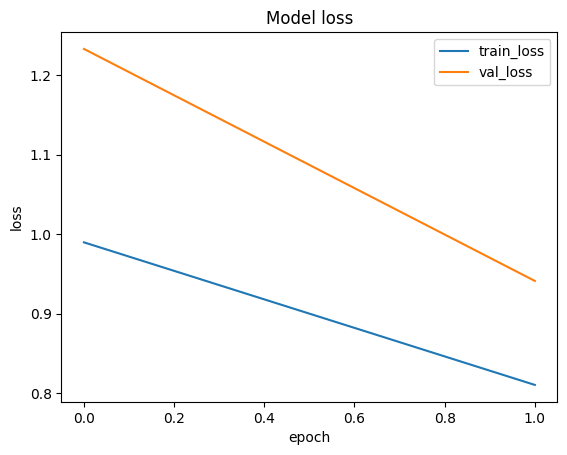

In [26]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train_loss', 'val_loss'])
plt.show()

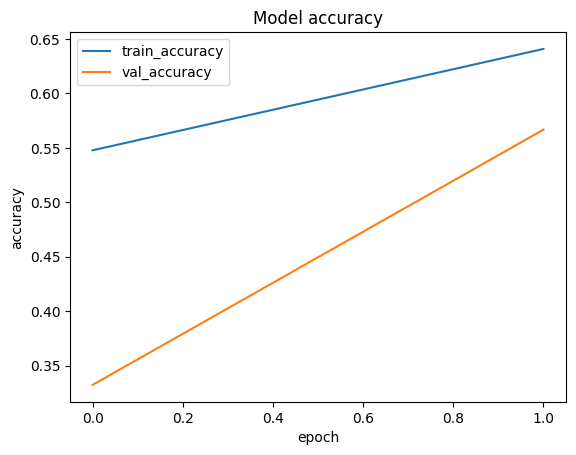

In [27]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train_accuracy', 'val_accuracy'])
plt.show()

In [28]:
lenet_model.evaluate(validation_dataset)

2278/2278 [==============================] - 13s 6ms/step - loss: 0.9412 - accuracy: 0.5667 - top_k_accuracy: 0.8139


[0.9412457942962646, 0.5667251944541931, 0.8138718008995056]

In [29]:
validation_dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 3), dtype=tf.float32, name=None))>

In [30]:
training_dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 3), dtype=tf.float32, name=None))>

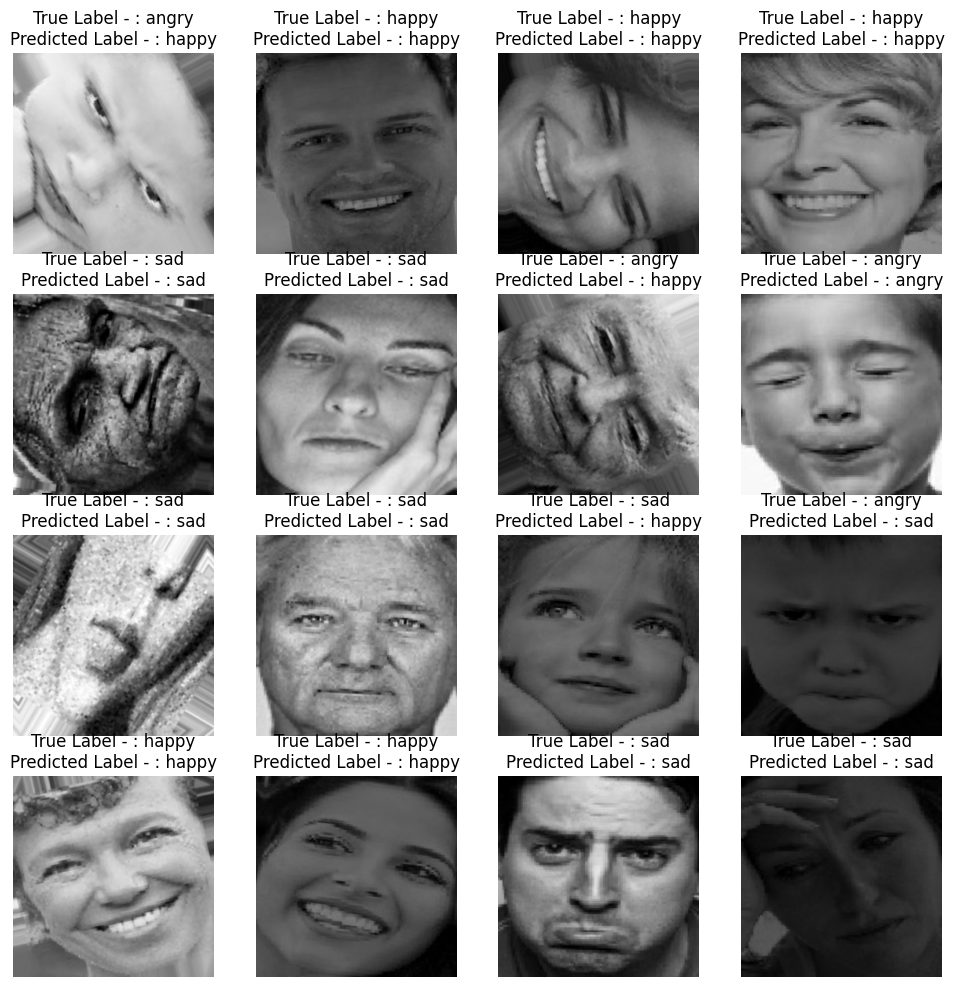

In [35]:
plt.figure(figsize = (12,12))

for images, labels in training_dataset.take(16):
    for i in range(16):
        ax = plt.subplot(4,4, i+1)
        plt.imshow(images[i]/255.)
        plt.title("True Label - : " + CONFIGURATION["CLASS_NAMES"][tf.argmax(labels[i], axis = -1).numpy()]
                  + "\n" + "Predicted Label - : "
                  + CONFIGURATION["CLASS_NAMES"][int(tf.argmax(lenet_model(tf.expand_dims(images[i], axis = 0)), axis =-1).numpy()[0])] )
        plt.axis("off")

# Cut mix data augmentation

In [36]:
def box(lamda):
  r_x = tf.cast(tfp.distributions.Uniform(0, CONFIGURATION["IM_SIZE"]).sample(1)[0], dtype = tf.int32)
  r_y = tf.cast(tfp.distributions.Uniform(0, CONFIGURATION["IM_SIZE"]).sample(1)[0], dtype = tf.int32)

  r_w = tf.cast(CONFIGURATION["IM_SIZE"]*tf.math.sqrt(1-lamda), dtype = tf.int32)
  r_h = tf.cast(CONFIGURATION["IM_SIZE"]*tf.math.sqrt(1-lamda), dtype = tf.int32)

  r_x = tf.clip_by_value(r_x - r_w//2, 0, CONFIGURATION["IM_SIZE"])
  r_y = tf.clip_by_value(r_y - r_h//2, 0, CONFIGURATION["IM_SIZE"])

  x_b_r = tf.clip_by_value(r_x + r_w//2, 0, CONFIGURATION["IM_SIZE"])
  y_b_r = tf.clip_by_value(r_y + r_h//2, 0, CONFIGURATION["IM_SIZE"])

  r_w = x_b_r - r_x
  if(r_w == 0):
    r_w  = 1

  r_h = y_b_r - r_y
  if(r_h == 0):
    r_h = 1

  return r_y, r_x, r_h, r_w

In [38]:
def cutmix(train_dataset_1, train_dataset_2):
  (image_1,label_1), (image_2, label_2) = train_dataset_1, train_dataset_2

  lamda = tfp.distributions.Beta(2,2)
  lamda = lamda.sample(1)[0]

  r_y, r_x, r_h, r_w = box(lamda)

  crop_1 = tf.image.crop_to_bounding_box(image_1, r_y, r_x, r_h, r_w)
  pad_1 = tf.image.pad_to_bounding_box(crop_1, r_y, r_x, CONFIGURATION["IM_SIZE"], CONFIGURATION["IM_SIZE"])

  crop_2 = tf.image.crop_to_bounding_box(image_2, r_y, r_x, r_h, r_w)
  pad_2 = tf.image.pad_to_bounding_box(crop_2, r_y, r_x, CONFIGURATION["IM_SIZE"], CONFIGURATION["IM_SIZE"])

  image = image_1 - pad_1 + pad_2

  lamda = tf.cast(1- (r_w*r_h)/(CONFIGURATION["IM_SIZE"]*CONFIGURATION["IM_SIZE"]), dtype = tf.float32)
  label = lamda*tf.cast(label_1, dtype = tf.float32) + (1-lamda)*tf.cast(label_2, dtype = tf.float32)

  return image, label

In [39]:
train_dataset_1 = train_dataset.map(
    augment_layer,
    num_parallel_calls = tf.data.AUTOTUNE
    )
train_dataset_2 = train_dataset.map(
    augment_layer,
    num_parallel_calls = tf.data.AUTOTUNE
    )

mixed_dataset = tf.data.Dataset.zip((train_dataset_1, train_dataset_2))

In [40]:
training_dataset_cut_mix = (
     mixed_dataset
     .map(cutmix, num_parallel_calls = tf.data.AUTOTUNE)
     .prefetch(tf.data.AUTOTUNE)
 )

Instructions for updating:
back_prop=False is deprecated. Consider using tf.stop_gradient instead.
Instead of:
results = tf.while_loop(c, b, vars, back_prop=False)
Use:
results = tf.nest.map_structure(tf.stop_gradient, tf.while_loop(c, b, vars))


In [41]:
training_dataset_cut_mix

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 3), dtype=tf.float32, name=None))>

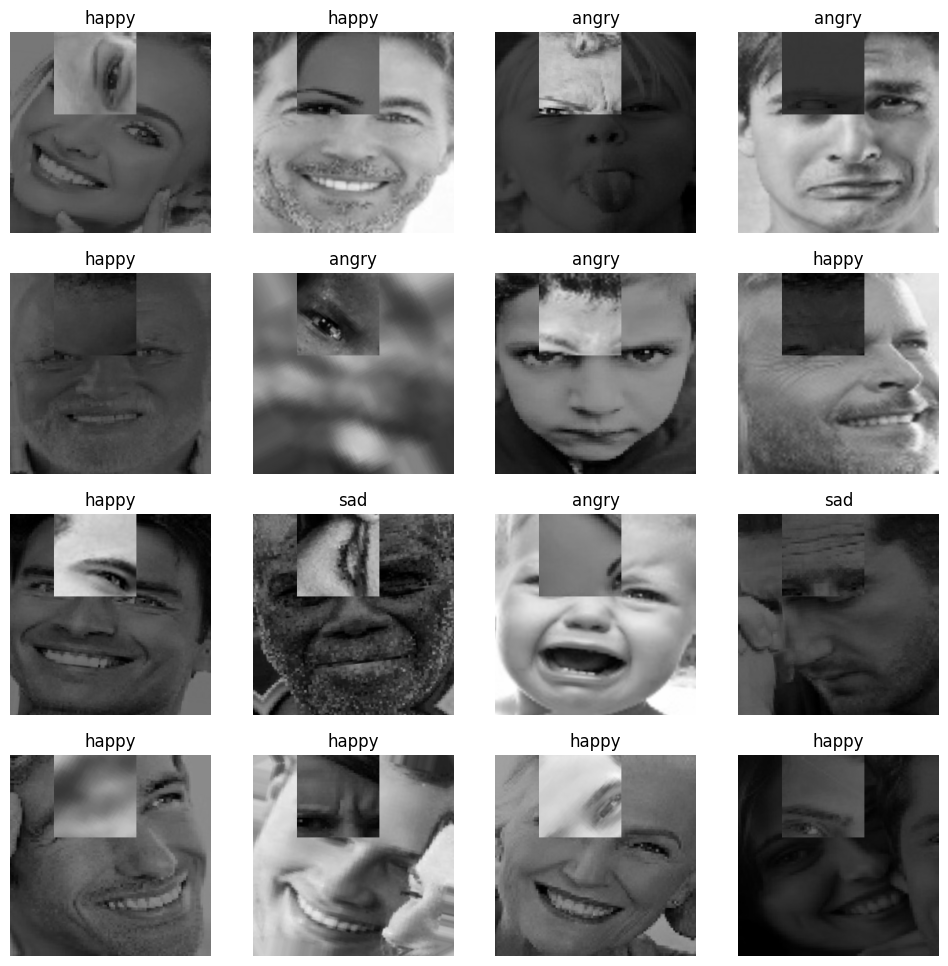

In [42]:
plt.figure(figsize = (12,12))

for images, labels in training_dataset_cut_mix.take(1):
  for i in range(16):
    ax = plt.subplot(4,4, i+1)
    plt.imshow(images[i]/255.)
    plt.title(CONFIGURATION["CLASS_NAMES"][tf.argmax(labels[i], axis = 0).numpy()])
    plt.axis("off")

In [43]:
predicted = []
labels = []

for im, label in validation_dataset:
  predicted.append(lenet_model(im).numpy())
  labels.append(label.numpy())

In [ ]:
predicted

[array([[0.05283065, 0.7305484 , 0.21662101]], dtype=float32),
 array([[0.12688884, 0.28266102, 0.59045017]], dtype=float32),
 array([[0.05023266, 0.5933656 , 0.35640174]], dtype=float32),
 array([[0.21639784, 0.39557433, 0.3880279 ]], dtype=float32),
 array([[0.04424682, 0.79560745, 0.16014571]], dtype=float32),
 array([[0.14435457, 0.04507231, 0.8105731 ]], dtype=float32),
 array([[0.06518687, 0.7576921 , 0.17712103]], dtype=float32),
 array([[0.07813784, 0.54600614, 0.37585604]], dtype=float32),
 array([[0.12975585, 0.4399224 , 0.43032175]], dtype=float32),
 array([[0.39814875, 0.09921139, 0.5026399 ]], dtype=float32),
 array([[0.19535093, 0.54957646, 0.2550726 ]], dtype=float32),
 array([[0.06190925, 0.682721  , 0.25536978]], dtype=float32),
 array([[0.263145  , 0.19471957, 0.5421354 ]], dtype=float32),
 array([[0.0519195 , 0.77656335, 0.17151718]], dtype=float32),
 array([[0.27688128, 0.16191018, 0.56120855]], dtype=float32),
 array([[0.22928825, 0.29480475, 0.475907  ]], dtype=fl

In [44]:
print(np.concatenate([np.argmax(labels[:-1], axis = -1).flatten(), np.argmax(labels[-1], axis = -1).flatten()]))
print(np.concatenate([np.argmax(predicted[:-1], axis = -1).flatten(), np.argmax(predicted[-1], axis = -1).flatten()]))

[1 2 1 ... 1 0 1]
[1 2 1 ... 1 2 2]


In [45]:
pred = np.concatenate([np.argmax(predicted[:-1], axis = -1).flatten(), np.argmax(predicted[-1], axis = -1).flatten()])
lab = np.concatenate([np.argmax(labels[:-1], axis = -1).flatten(), np.argmax(labels[-1], axis = -1).flatten()])

[[ 18 171 326]
 [  1 759 246]
 [  1 242 514]]


Text(0.5, 58.7222222222222, 'Predicted')

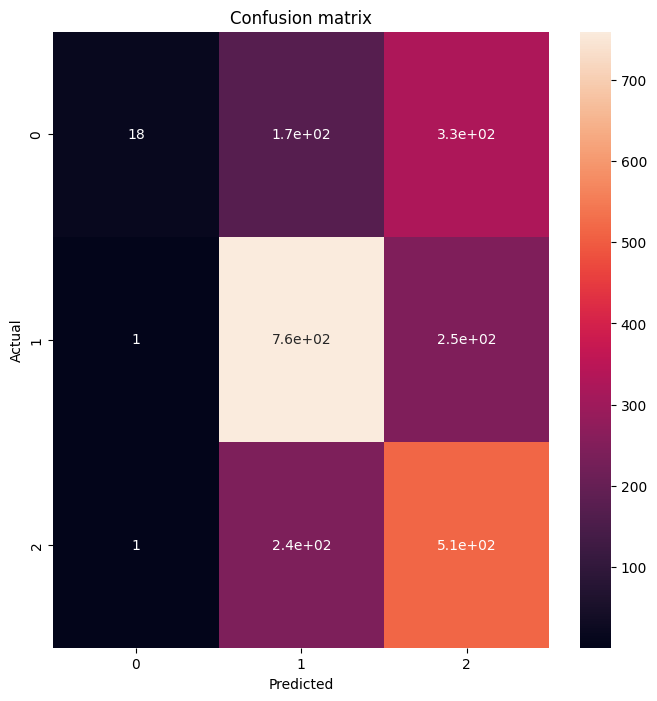

In [46]:
cm = confusion_matrix(lab, pred)
print(cm)
plt.figure(figsize=(8,8))

sns.heatmap(cm, annot=True,)
plt.title('Confusion matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')

# TFRecords

In [47]:
train_dataset

<_BatchDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 3), dtype=tf.float32, name=None))>

In [48]:
training_dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 3), dtype=tf.float32, name=None))>

In [49]:
training_dataset_record = (
    train_dataset
    .map(augment_layer, num_parallel_calls=tf.data.AUTOTUNE)
)

In [50]:
validation_dataset_record = (
    val_dataset
)

In [58]:
training_dataset_record = training_dataset_record.unbatch()

In [54]:
validation_dataset_record = validation_dataset_record.unbatch()

In [68]:
def create_example(image, label):

  bytes_feature = Feature(
      bytes_list=BytesList(value=[image]))

  int_feature = Feature(
      int64_list=Int64List(value=[label]))

  example = Example(
      features=Features(feature={
          'images': bytes_feature,
          'labels': int_feature,
      }))

  return example.SerializeToString()

In [69]:
NUM_SHARDS = 10
PATH = 'tfrecords/shard_{:02d}.tfrecord'

In [70]:
def encode_image(image, label):
  image = tf.image.convert_image_dtype(image, dtype=tf.uint8)
  image = tf.io.encode_jpeg(image)
  return image,tf.argmax(label)

In [71]:
encoded_dataset = (
  training_dataset_record
  .map(encode_image)
)

In [72]:
for shard_number in range(NUM_SHARDS):

  sharded_dataset = (
      encoded_dataset
      .shard(NUM_SHARDS, shard_number)
      .as_numpy_iterator()
  )

  with tf.io.TFRecordWriter(PATH.format(shard_number)) as file_writer:
    for encoded_image, encoded_label in sharded_dataset:

      example = create_example(encoded_image, encoded_label)
      file_writer.write(example)

In [73]:
tf.__version__

'2.12.0'

In [74]:
recons_dataset = tf.data.TFRecordDataset(
    filenames =[PATH.format(p) for p in range(NUM_SHARDS-2)] )
val_recons_dataset = tf.data.TFRecordDataset(
     filenames =[PATH.format(p) for p in range(NUM_SHARDS-2,NUM_SHARDS)] )

In [77]:
recons_dataset

<TFRecordDatasetV2 element_spec=TensorSpec(shape=(), dtype=tf.string, name=None)>

In [78]:
def parse_tfrecords(example):
    feature_description = {
          "images": tf.io.FixedLenFeature([], tf.string),
          "labels": tf.io.FixedLenFeature([], tf.int64),
      }

    example = tf.io.parse_single_example(example, feature_description)
    example["images"] = tf.image.convert_image_dtype(
        tf.io.decode_jpeg(
        example["images"], channels = 3), dtype = tf.float32)

    return example["images"], example["labels"]

In [79]:
parsed_dataset = (
    recons_dataset
    .map(parse_tfrecords)
    .batch(CONFIGURATION["BATCH_SIZE"])
    .prefetch(tf.data.AUTOTUNE)
)

In [80]:
val_parsed_dataset = (
     val_recons_dataset
     .map(parse_tfrecords)
     .batch(CONFIGURATION["BATCH_SIZE"])
     .prefetch(tf.data.AUTOTUNE)
 )

In [81]:
parsed_dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, None, None, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

In [82]:
val_parsed_dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, None, None, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

In [83]:
for i in parsed_dataset.take(1):
  print(i)

(<tf.Tensor: shape=(32, 256, 256, 3), dtype=float32, numpy=
array([[[[0.50980395, 0.50980395, 0.50980395],
         [0.7019608 , 0.7019608 , 0.7019608 ],
         [0.9725491 , 0.9725491 , 0.9725491 ],
         ...,
         [0.25882354, 0.25882354, 0.25882354],
         [0.76470596, 0.76470596, 0.76470596],
         [0.34509805, 0.34509805, 0.34509805]],

        [[0.43529415, 0.43529415, 0.43529415],
         [0.6313726 , 0.6313726 , 0.6313726 ],
         [0.0627451 , 0.0627451 , 0.0627451 ],
         ...,
         [0.5882353 , 0.5882353 , 0.5882353 ],
         [0.28627452, 0.28627452, 0.28627452],
         [0.3803922 , 0.3803922 , 0.3803922 ]],

        [[0.21176472, 0.21176472, 0.21176472],
         [0.5137255 , 0.5137255 , 0.5137255 ],
         [0.30588236, 0.30588236, 0.30588236],
         ...,
         [0.38823533, 0.38823533, 0.38823533],
         [0.48235297, 0.48235297, 0.48235297],
         [0.49411768, 0.49411768, 0.49411768]],

        ...,

        [[0.21176472, 0.21176472

In [85]:
loss_function = SparseCategoricalCrossentropy()

metrics = [SparseCategoricalAccuracy(name = "accuracy")]

lenet_model.compile(
    optimizer = Adam(learning_rate = CONFIGURATION["LEARNING_RATE"]),
    loss = loss_function,
    metrics = metrics,)

In [87]:
history = lenet_model.fit(
    parsed_dataset,
    #validation_data = validation_dataset,
    epochs = 2,
    verbose = 1,
    #class_weight = class_weights,
    #callbacks = [WandbCallback(), LogConfMatrix(), LogResultsTable()]
    )

Epoch 1/2
170/170 [==============================] - 17s 64ms/step - loss: 1.1138 - accuracy: 0.4368
Epoch 2/2
170/170 [==============================] - 10s 57ms/step - loss: 0.4905 - accuracy: 0.8217


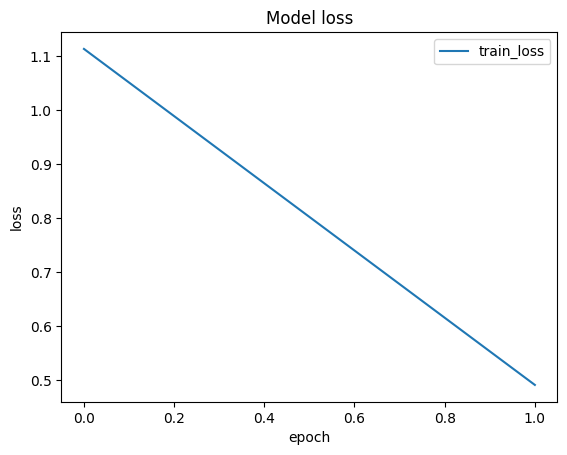

In [89]:
plt.plot(history.history['loss'])
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train_loss', 'val_loss'])
plt.show()

In [90]:
lenet_model.evaluate(val_parsed_dataset)

43/43 [==============================] - 3s 63ms/step - loss: 13.0996 - accuracy: 0.3245


[13.09960651397705, 0.3245033025741577]

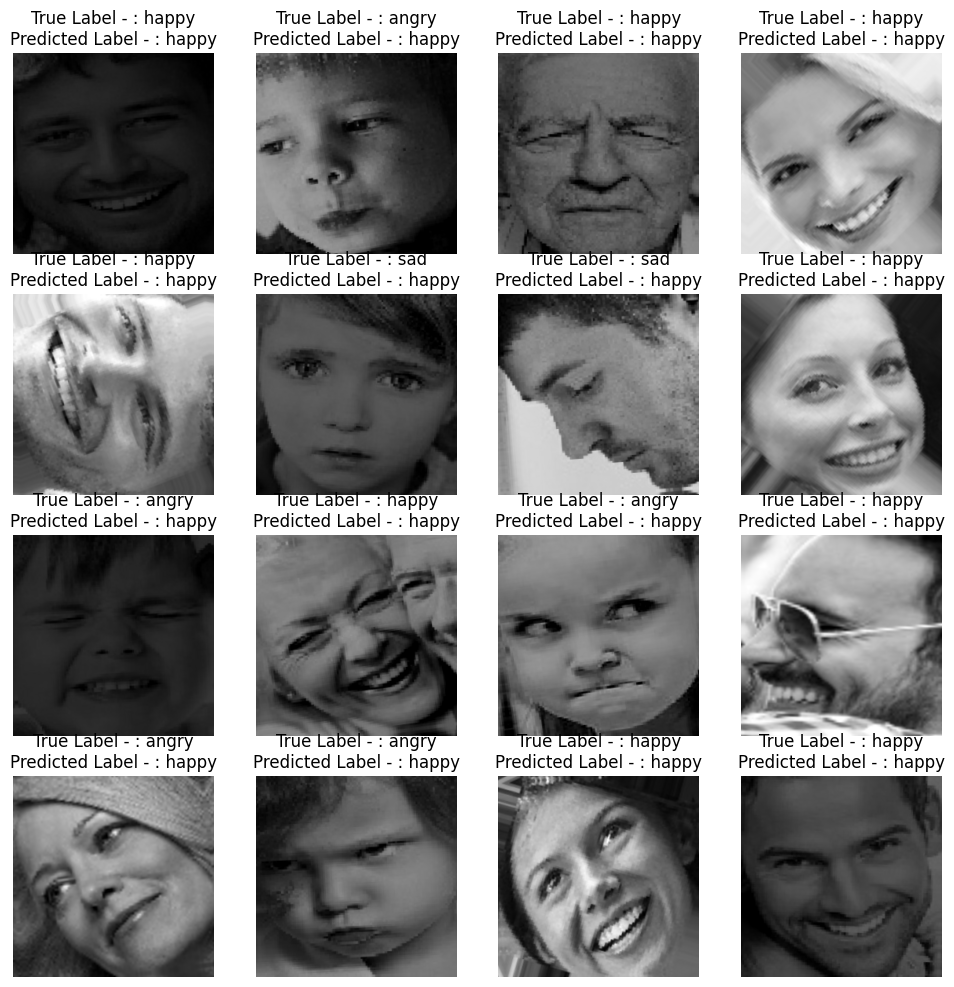

In [93]:
plt.figure(figsize = (12,12))

for images, labels in training_dataset.take(16):
    for i in range(16):
        ax = plt.subplot(4,4, i+1)
        plt.imshow(images[i]/255.)
        plt.title("True Label - : " + CONFIGURATION["CLASS_NAMES"][tf.argmax(labels[i], axis = -1).numpy()]
                  + "\n" + "Predicted Label - : "
                  + CONFIGURATION["CLASS_NAMES"][int(tf.argmax(lenet_model(tf.expand_dims(images[i], axis = 0)), axis =-1).numpy()[0])] )
        plt.axis("off")

In [94]:
!zip -r folder_name.zip tfrecords/

  adding: tfrecords/ (stored 0%)
  adding: tfrecords/shard_09.tfrecord (deflated 1%)
  adding: tfrecords/shard_03.tfrecord (deflated 1%)
  adding: tfrecords/shard_01.tfrecord (deflated 1%)
  adding: tfrecords/shard_00.tfrecord (deflated 1%)
  adding: tfrecords/shard_04.tfrecord (deflated 1%)
  adding: tfrecords/shard_02.tfrecord (deflated 1%)
  adding: tfrecords/shard_06.tfrecord (deflated 1%)
  adding: tfrecords/shard_05.tfrecord (deflated 1%)
  adding: tfrecords/shard_08.tfrecord (deflated 1%)
  adding: tfrecords/shard_07.tfrecord (deflated 1%)
